# Exploratory Analysis

**Sample Scenario**

We would like to be able to use attributes of customers to estimate their spending score.
In doing so, we can target those customers that are likely to be most profitable.

Our target variable is spending_score.
Currently the only customer data we have available to use in this project is age, annual_income and gender.
It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

## Wrangle Data 

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_excs as wrangle

In [2]:
df = wrangle.get_mall_customers('SELECT * FROM customers')
train, validate, test = wrangle.train_validate_test_split(df)

In [3]:
df = train

In [20]:
df.head()

,gender,age,annual_income,spending_score,age_bin,income_bin
customer_id,,,,,,
64,Female,54,47,59,"(40, 80]","(40, 70]"
49,Female,29,40,42,"(0, 40]","(0, 40]"
25,Female,54,28,14,"(40, 80]","(0, 40]"
137,Female,44,73,7,"(40, 80]","(70, 140]"
177,Male,58,88,15,"(40, 80]","(70, 140]"


NB. We'll explore unscaled, but scale before modeling.

## Answer Questions

### What is the distribution of each of the variables?

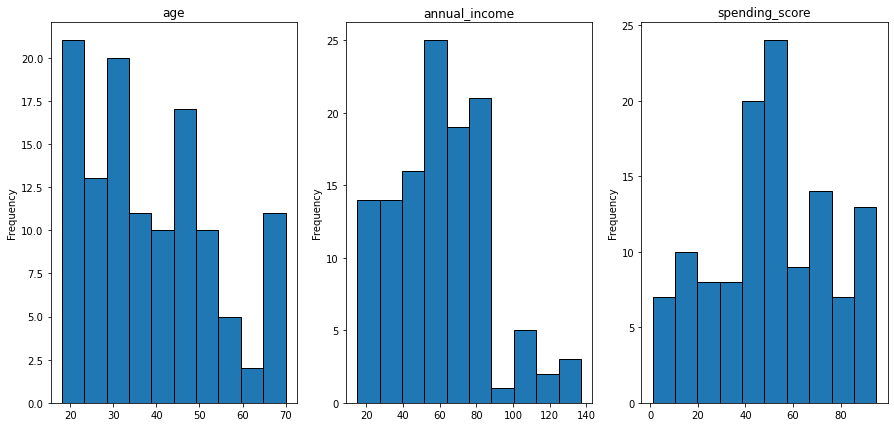

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

<AxesSubplot:>

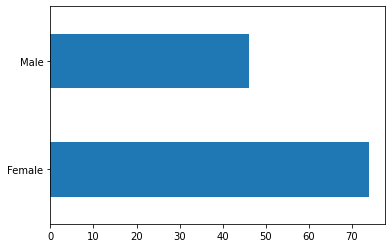

In [21]:
df.gender.value_counts().plot.barh()

**Takeaways:**

- Spending score is ~ normal
- age + annual income have a long tail on the right -- i.e. (Right skewed)
- More female observations then male

### Does spending score differ across gender?

1. Viz gender against spending score
1. Stats test to confirm

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

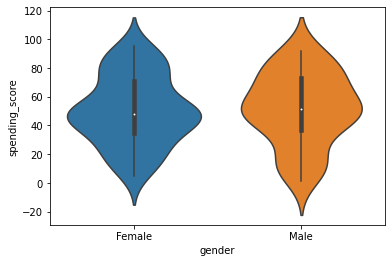

In [22]:
sns.violinplot(data = df, y = "spending_score", x = "gender")

Text(0.5, 1.0, 'Is there a difference in spending score for\nmale vs. female customers?')

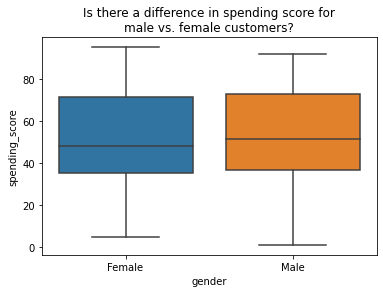

In [5]:
sns.boxplot(data=df, y='spending_score', x='gender')
plt.title("Is there a difference in spending score for\nmale vs. female customers?")

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

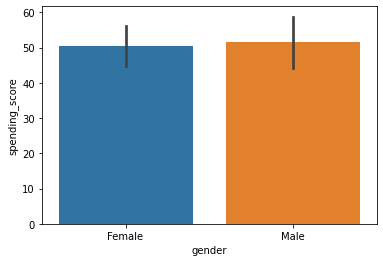

In [23]:
sns.barplot(data = df, y = "spending_score", x = "gender")

**Takeaways:**

- Seems like there's not much difference in spending score between gender.

T-test

- one-tailed or two-tailed? two-tailed: because we are looking for any difference
- one-sample or two-sampled? two-sample: because we are looking at the average spending score of two seperate groups.

**Levene's Test**: test for equal variance

- $H_0$ there is no difference in spending score variance between the two samples.
- $H_a$ there is a difference in spending score variance between the two samples.

In [6]:
stats.levene(
    df.query('gender == "Male"').spending_score,
    df.query('gender == "Female"').spending_score,
)

LeveneResult(statistic=0.10928566487557842, pvalue=0.7415451203905439)

In [24]:
# A high p-value means that we failed to reject the null hypothesis

In [7]:
stats.ttest_ind(
    df.query('gender == "Male"').spending_score,
    df.query('gender == "Female"').spending_score,
    equal_var=True,
)

Ttest_indResult(statistic=0.24250945188004078, pvalue=0.8088064406384925)

In [25]:
# A high p-value means that we failed to reject the null hypothesis
# we can conclude that there is no significant difference in spending score between males and females.

**Conclusion:**

### Is there a relationship between spending score and annual income?

1. Viz annual_income by spending_score
2. Spearman's test if we want to confirm correlation (pearson's assumes normally distributed vars)

<AxesSubplot:title={'center':'Is there a relationship\nbetween annual income and spending score?'}, xlabel='annual_income', ylabel='spending_score'>

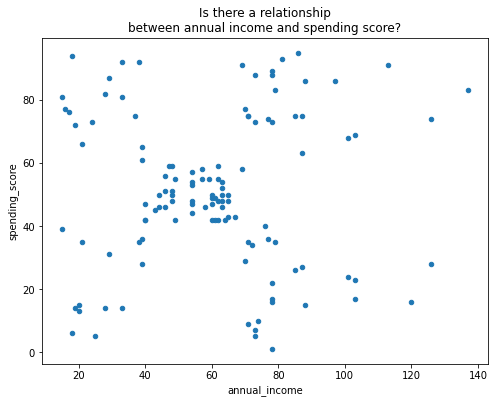

In [26]:
df.plot.scatter(
    x="annual_income",
    y="spending_score",
    title='Is there a relationship\nbetween annual income and spending score?',
    figsize=(8, 6),
)

**Conclusion:**

- looks like an "x"
- not a linear relationship
- middle cluster is the most dense
- this might indicate that there are two seperate linear relationships one negative and one positive

Is there a relationship between age and spending score?

1. Viz age by spending_score. 
1. Create age bins and compare

<AxesSubplot:title={'center':'Is there a relationship between age and spending score?'}, xlabel='age', ylabel='spending_score'>

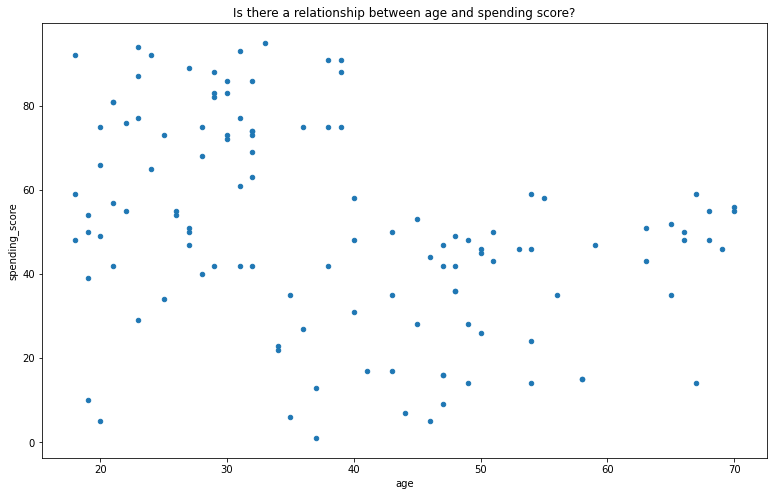

In [27]:
df.plot.scatter(y='spending_score', x='age', title='Is there a relationship between age and spending score?', figsize=(13, 8))

**Takeaways:**

- spending score trails off for older individuals
- younger folks seem to have a higher spending score
- after age 40 spending score seems to decrease

In [28]:
x = pd.Series(range(1,11))
x

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
dtype: int64

In [29]:
pd.cut(x, bins = [0,7,9,11])

0     (0, 7]
1     (0, 7]
2     (0, 7]
3     (0, 7]
4     (0, 7]
5     (0, 7]
6     (0, 7]
7     (7, 9]
8     (7, 9]
9    (9, 11]
dtype: category
Categories (3, interval[int64]): [(0, 7] < (7, 9] < (9, 11]]

In [10]:
df['age_bin'] = pd.cut(df.age, [0, 40, 80])
df.head()

,gender,age,annual_income,spending_score,age_bin
customer_id,,,,,
64,Female,54,47,59,"(40, 80]"
49,Female,29,40,42,"(0, 40]"
25,Female,54,28,14,"(40, 80]"
137,Female,44,73,7,"(40, 80]"
177,Male,58,88,15,"(40, 80]"


<AxesSubplot:title={'center':'Distributions of age_bin'}>

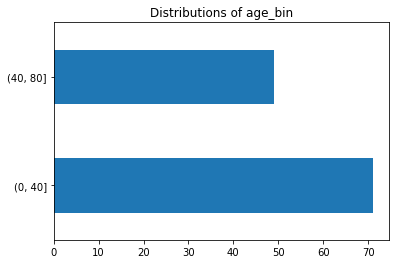

In [30]:
df.age_bin.value_counts().plot.barh(title = "Distributions of age_bin")

<AxesSubplot:xlabel='age_bin', ylabel='spending_score'>

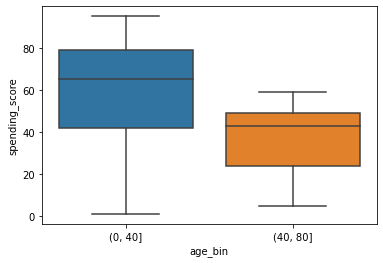

In [31]:
sns.boxplot(data=df, y='spending_score', x='age_bin')

In [32]:
stats.levene(
    df[df.age <= 40].spending_score,
    df[df.age > 40].spending_score,
)

LeveneResult(statistic=9.154464052447656, pvalue=0.0030460560375097914)

**Conclusion:**

We reject the null hypothesis that the variance in spending score is the same for folks less than or equal to 40 and above 40.

In [13]:
stats.ttest_ind(
    df[df.age <= 40].spending_score,
    df[df.age > 40].spending_score,
    equal_var=False,
)

Ttest_indResult(statistic=6.2431568169013785, pvalue=7.026347337563538e-09)

**Conclusion:**
- We can conclude that individuals below the age of 40 have a higher spending score then individuals above the age of 40

### If we control for age, does spending score differ across annual income?

1. Viz annual income by spending score for each age bin
2. Analyze each age bin separately

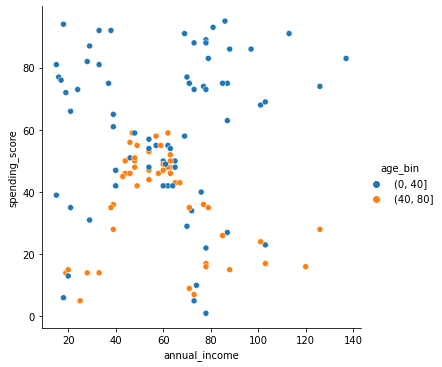

In [36]:
sns.relplot(data=df, y='spending_score', x='annual_income', hue = "age_bin")

**Takeaways:**

- 0 through 40 still has an x-shape
- 40+ crowd is just the bottom half of the x

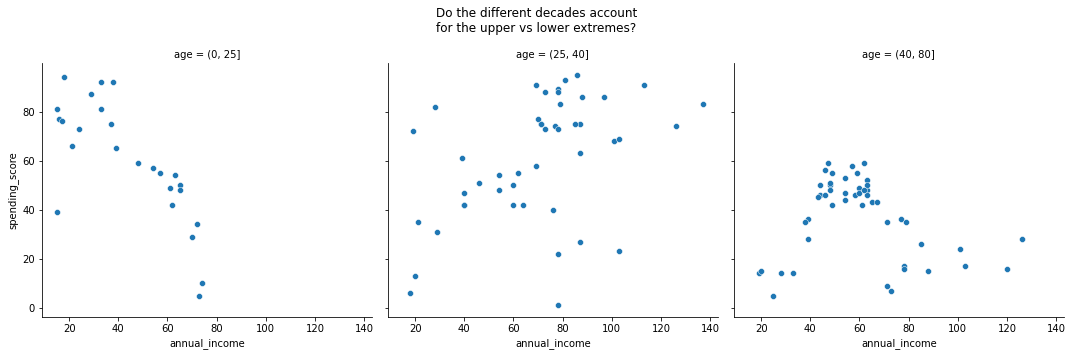

In [47]:
sns.relplot(
    data=df,
    y='spending_score',
    x='annual_income',
    col=pd.cut(df.age, bins=[0, 25, 40, 80]),
)
plt.suptitle("Do the different decades account\nfor the upper vs lower extremes?")
plt.tight_layout()

**Takeaways:**

- 30 - 40 *almost* looks linear
- 0 - 30 *almost* looks like a negative linear relationship
- 40 - 80 *almost* looks quadradic

### Does gender explain the high income-low spending score and/or low income-low spending score in the under 40 group?

Text(0.5, 1.0, 'Does gender acccount for upper vs lower\nin the younger age group?')

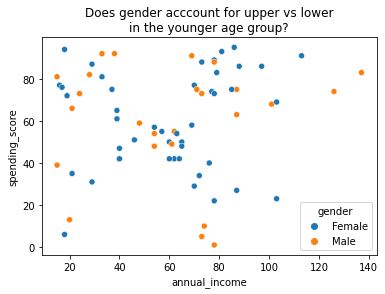

In [48]:
sns.scatterplot(
    x='annual_income',
    y='spending_score',
    data=df[df.age <= 40],
    hue='gender',
)
plt.title("Does gender acccount for upper vs lower\nin the younger age group?")

Aside: scatterplot vs relplot
    
- scatterplot works with axes
- relplot works with figures

___

- seaborn is built on top of matplotlib
- every matplotlib axis lives within a figure
- a figure can have 1 or more axes in it (2+ is when we have subplots)

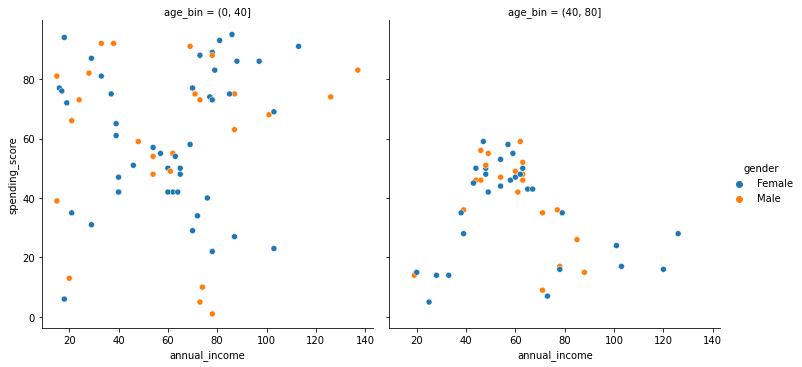

In [55]:
sns.relplot(
    x='annual_income',
    y='spending_score',
    data=df,
    hue='gender',
    col = "age_bin"
)
plt.show()

**Takeaways:**

- gender isnt terrible helpful in finding spending score in this new context

### If we control for annual income, does spending score differ across age?

Because of the shape of annual income with spending score, I will create 3 bins of income: \[0, 40), \[40, 70), \[70, 140\]. 

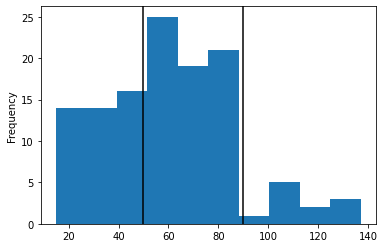

In [62]:
ax = df.annual_income.plot.hist()
ax.axvline(50, color = "black")
ax.axvline(90, color = "black")

In [66]:
df['income_bin'] = pd.cut(df.annual_income, [0, 40, 70, 140])

In [67]:
df.head()

,gender,age,annual_income,spending_score,age_bin,income_bin
customer_id,,,,,,
64,Female,54,47,59,"(40, 80]","(40, 70]"
49,Female,29,40,42,"(0, 40]","(0, 40]"
25,Female,54,28,14,"(40, 80]","(0, 40]"
137,Female,44,73,7,"(40, 80]","(70, 140]"
177,Male,58,88,15,"(40, 80]","(70, 140]"


Text(0.5, 1.0, 'How does age compare to spending score\nwithin each income bin?')

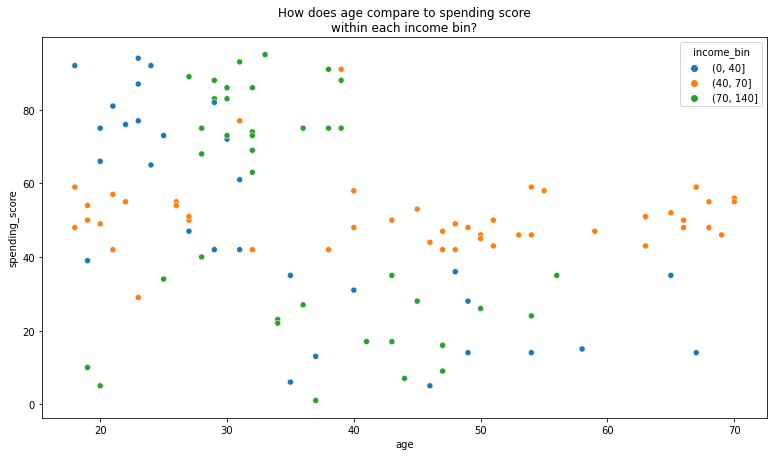

In [70]:
plt.figure(figsize = (13,7))
sns.scatterplot(
    x='age',
    y='spending_score',
    data=df,
    hue='income_bin',
)
plt.title("How does age compare to spending score\nwithin each income bin?")

**Takeaways:**

## Summary

- Annual income and spending score are good canidates for clustering
- older folks past some cutoff(40+) tend to not have high values for spending score.
- younger folks (25-) with low income and high spending score.
- Gender doesnt really seem to corralate with our data in a meaningful way.